In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
import statsmodels.formula.api as smf
from math import exp
from sklearn import linear_model, cross_validation
import scipy.stats as prr
import numpy as np
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.formula.api as sm
import itertools

## Regression Class

In [58]:
class Regression:
    def __init__(self, pathToData):
        self.data = pd.read_csv(pathToData, index_col=0)

    def getDataFrame(self):
        return self.data

    
    
    # get collinearity (r^2 value) of a pair of columns
    def getCollinearityScore(self, dependentCol, independentCol):
        array = self.data.values
        X = array[:, independentCol]
        Y = array[:, dependentCol]

        return prr.pearsonr(X, Y)
        # GET SUBTABLE CONTAINING ONLY THE INDEPENDENT COLUMN AND DEPENDENT COLUMN
        # df2 = self.data.iloc[:, [independentCol, dependentCol]]
        # CREATE FITTED MODEL USING ORDINARY LEAST SQUARES REGRESSION
        # lm = smf.ols(formula='Sales ~ TV', data=df2).fit()
        # RETURN RSQUARED VALUE FOR THE MODEL
        # return lm.rsquared

    # print collinearities (r^2 value) of each pair of columns
    def printAllCollinearities(self):
        array = self.data.values
        length_col = self.data.shape[1]
        while(0 != length_col-1):
            for x in range(0, length_col-1):
                X = array[:, x]
                Y = array[:, length_col-1]

                print("Collinearity between "+self.data.columns.values[x]+" & "+self.data.columns.values[length_col-1]+" = "+str(prr.pearsonr(X, Y)))
            length_col -= 1

    def getSubTable(self, col_names):
        array = self.data
        return array.loc[:, col_names]
            
    def getFittedRegressionModel(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        print("R^2 score: "+str(model.score(X, Y)))
        m = model.coef_
        b = model.intercept_
        # print("Intercept=" + str(b) + " Coefficient=" + str(m))
        return model

    def getBestFeaturesRCEV(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        feature_names = self.data.columns.values
        model = linear_model.LinearRegression()
        selector = RFECV(estimator=model, cv=10)
        selector.fit(X, Y)
        print(selector.ranking_)
        print("Optimal number of features3: " + str(selector.n_features_))
        print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), col_names)))
        print(selector.support_)
        
    def getXVals(self, col_names):
        #array = self.data
        array = self.data.copy()
        X = array.loc[:, col_names]
        return X
    
    def getYVals(self, col_names):
        #array = self.data
        array = self.data.copy()
        X = array.loc[:, col_names]
        return X
        
    def kFoldTest(self, col_names, dependent_col_name, test_row_num):
        #array = self.data
        array = self.data.copy()
        array = array.drop(array.index[test_row_num])
        
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        m = model.coef_
        b = model.intercept_
        return model
    
    def kFoldTest2(self, col_names, dependent_col_name, slice_size):
        #array = self.data
        array = self.data.copy()
        original = self.data.copy()
        iterations = len(array.index)/slice_size
        if(len(array.index)%slice_size>0):
            iterations = int(iterations)+1
            
        for j in range(0, iterations):
            for i in range(0,len(array.index)):
                if (i/slice_size==j):
                    array = array.drop(array.index[i])

            X = original.loc[:, col_names]
            Y = original.loc[:, dependent_col_name]
            model = linear_model.LinearRegression()
            model.fit(X, Y)
            m = model.coef_
            b = model.intercept_
            
            predicted_vals = []
            observed_vals = []
            array = self.data.copy()
            size = 0
            for i in range(0,len(array.index)):
                #print(str(i)+" / "+str(slice_size)+" == "+str(j))
                if (int(i/slice_size)==j):
                    #print("WENT IN!")
                    size += 1
                    print("length:"+str(len(X.index))+" index:"+str(i))
                    predicted_vals.append(model.predict(X.iloc[i , :].values.reshape(1,-1))[0])
                    print(Y.iloc[i])
                    observed_vals.append(Y.iloc[i])
            rms = sqrt(mean_squared_error(observed_vals, predicted_vals))
            rms = rms*((100*slice_size)/sum(observed_vals))
            print("Trained using slice "+str(j)+": RMSE = "+str(rms))  
            print("slice size: "+str(size))
            
    def statsmodelsRegressionSummary(self, col_names, dependent_col_name):
        array = self.data.copy()
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        result = sm.OLS( Y, X ).fit()
        return result

        


## Trip Generation Class

In [50]:
class TripGeneration:

    def __init__(self, pathToData, dependent_col_name):
        self.pathToData = pathToData
        self.dependent_col_name = dependent_col_name
        self.production_col_names = []
        self.production_constant = 0
        self.production_intercepts = []
        self.attraction_col_names = []
        self.attraction_constant = 0
        self.attraction_intercepts = []
        self.production_score = 0
        self.attraction_score = 0
        self.balancing_factor = 0
        
    def printAttributes(self):
        print("Attributes")
        print(self.production_col_names)
        print(self.production_constant)
        print(self.production_intercepts)
        print(self.attraction_col_names)
        print(self.attraction_constant)
        print(self.attraction_intercepts)

    def setProductionParameters(self, production_col_names, production_constant, production_intercepts):
        self.production_col_names = production_col_names
        self.production_constant = production_constant
        self.production_intercepts = production_intercepts
        
    def setAttractionParameters(self, attraction_col_names, attraction_constant, attraction_intercepts):
        self.attraction_col_names = attraction_col_names
        self.attraction_constant = attraction_constant
        self.attraction_intercepts = attraction_intercepts
        
    
    # get trip production score for 'zone'
    def getWholeTripProductionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.production_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.production_score += self.production_constant
            for j in range(0,len(row_values)):
                self.production_score += int(row_values[j]*self.production_intercepts[j])
            #print("SELFPROD CURR: "+str(self.production_score))
        return int(self.production_score)

    # get trip attraction score for 'zone'
    def getWholeTripAttractionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.attraction_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.attraction_score += self.attraction_constant
            for j in range(0,len(row_values)):
                self.attraction_score += int(row_values[j]*self.attraction_intercepts[j])
            #print("SELFATTR CURR: "+str(self.attraction_score))
        return int(self.attraction_score)
    
    def getZoneTripProductionScore(self, zone_number):
        self.production_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.production_score += self.production_constant
        for j in range(0,len(row_values)):
            self.production_score += row_values[j]*self.production_intercepts[j]

        return self.production_score
    
    def getZoneTripAttractionScore(self, zone_number):
        self.attraction_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.attraction_score += self.attraction_constant
        for j in range(0,len(row_values)):
            self.attraction_score += row_values[j]*self.attraction_intercepts[j]

        return self.attraction_score

    def doTripBalancing(self):
        self.balancing_factor = self.production_score/self.attraction_score
        self.attraction_score = self.balancing_factor * self.attraction_score
        self.production_score = self.balancing_factor * self.production_score
        # Implement trip balancing here VOID
        
    def getBalancingFactor(self):
        return self.balancing_factor
    
    def printAllZonalTripsProductionAttraction(self):
        productionScores = []
        attractionScores = []
        df = pd.DataFrame(columns=('Trip Production', 'Trip Atraction'))
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            attr_score = 0
            prod_score = 0
            attr_row_values = data.loc[x, self.attraction_col_names].values
            prod_row_values = data.loc[x, self.production_col_names].values
            attr_score += self.attraction_constant
            prod_score += self.production_constant
            for j in range(0,len(attr_row_values)):
                attr_score += attr_row_values[j]*self.attraction_intercepts[j]
            total_attraction += attr_score
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            df.loc[x] = [int(prod_score),int(attr_score)]
            productionScores.append(int(prod_score))
            attractionScores.append(int(attr_score))
            #print("Zone "+str(x)+": Production="+str(prod_score)+" , Attraction="+str(attr_score))
        return df, productionScores, attractionScores;
        #print("Total Production="+str(total_production)+" , Total Attraction="+str(total_attraction))
        
    def getTripProductionScores(self):
        productionScores = []
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            prod_score = 0
            prod_row_values = data.loc[x, self.production_col_names].values
            prod_score += self.production_constant
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            productionScores.append(prod_score)
        return productionScores
    
    def getProductionSubTable(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        return data.loc[:, self.production_col_names]

        


# DATA
### Expected available parameters from the MMUTIS Update and Enhancement Project (MUCEP) Database

In [51]:
dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


### Fused Zonal and Amenity data (OpenStreetMap)

In [52]:
dummy_data_amenities = pd.read_csv('DummyDataRegressionAmenitiex.csv', index_col=0)
dummy_data_amenities.head()

,sust_amt,educ_amt,tran_amt,heal_amt,fina_amt,comm_amt,ente_amt,othe_amt,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,58,86,54,43,44,2,0,97,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,214,41,43,65,104,1,7,68,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1129,47,138,102,467,7,26,147,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,23,14,18,16,15,3,0,42,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,184,14,36,42,78,3,4,44,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


# DATA PREPARATION (Example Plan)

## Collinearity Checking using Peasrson Correlation (correlation coefficient, 2-tailed p-value)

In [53]:
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)
array = regression.getDataFrame().values
print("All collinearities:")
regression.printAllCollinearities()

All collinearities:
Collinearity between no_hh & trips = (0.92914760415527753, 7.1205170410730196e-08)
Collinearity between avg_income & trips = (0.91992035789848337, 1.7354578828442896e-07)
Collinearity between mem_no & trips = (0.91247798270778113, 3.305852610863916e-07)
Collinearity between no_mem_educwork & trips = (0.91764041951966036, 2.1277373172145904e-07)
Collinearity between comm_area & trips = (0.70239128224202696, 0.0016671293361775938)
Collinearity between park_area & trips = (0.94004785612710895, 2.1005501466413752e-08)
Collinearity between indu_area & trips = (0.15090461252797308, 0.56317607573574535)
Collinearity between agri_area & trips = (0.70269953374106242, 0.0016558823959018866)
Collinearity between resi_area & trips = (0.74431330821911379, 0.00061114429021143885)
Collinearity between util_area & trips = (0.85172785701036735, 1.4351618108703435e-05)
Collinearity between othe_area & trips = (nan, 1.0)
Collinearity between no_hh & othe_area = (nan, 1.0)
Collinearity

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


### Checking for Optimal Features using Recursive Feature Elimination with Cross-Validation

In [54]:
col_names = regression.getDataFrame().columns.values[0:11]
print(str(1))
dep_col_name = "trips"
print(str(2))
regression.getBestFeaturesRCEV(col_names, dep_col_name)
print(str(3))
col_names

1
2
[ 1  5  2  3  6  9  8  4  7  1 10]
Optimal number of features3: 2
[(1, 'no_hh'), (1, 'util_area'), (2, 'mem_no'), (3, 'no_mem_educwork'), (4, 'agri_area'), (5, 'avg_income'), (6, 'comm_area'), (7, 'resi_area'), (8, 'indu_area'), (9, 'park_area'), (10, 'othe_area')]
[ True False False False False False False False False  True False]
3


array(['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area',
       'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area',
       'othe_area'], dtype=object)

In [55]:
data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)
array2 = regression2.getDataFrame().values
print("All collinearities:")
regression2.printAllCollinearities()

All collinearities:
Collinearity between sust_amt & trips = (0.61766649945179353, 0.0082397277247921313)
Collinearity between educ_amt & trips = (0.79298891907477898, 0.00014625516874859079)
Collinearity between tran_amt & trips = (0.82659474668514443, 4.2998072277589239e-05)
Collinearity between heal_amt & trips = (0.7836582956773025, 0.00019770168871971209)
Collinearity between fina_amt & trips = (0.56994354452005569, 0.016913167026585154)
Collinearity between comm_amt & trips = (0.40246884564223007, 0.10924012866786645)
Collinearity between ente_amt & trips = (0.63964348181274389, 0.0056909899532994433)
Collinearity between othe_amt & trips = (0.81734620789132073, 6.1700600812943568e-05)
Collinearity between comm_area & trips = (0.70239128224202696, 0.0016671293361775938)
Collinearity between park_area & trips = (0.94004785612710895, 2.1005501466413752e-08)
Collinearity between indu_area & trips = (0.15090461252797308, 0.56317607573574535)
Collinearity between agri_area & trips = (0

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [56]:
col_names2 = regression2.getDataFrame().columns.values[1:15]
print(str(1))
dep_col_name2 = "trips"
print(str(2))
regression2.getBestFeaturesRCEV(col_names2, dep_col_name2)
print(str(3))
col_names2

1
2
[5 1 1 1 1 1 1 3 1 4 1 2 1 6]
Optimal number of features3: 9
[(1, 'agri_area'), (1, 'comm_amt'), (1, 'ente_amt'), (1, 'fina_amt'), (1, 'heal_amt'), (1, 'othe_amt'), (1, 'park_area'), (1, 'tran_amt'), (1, 'util_area'), (2, 'resi_area'), (3, 'comm_area'), (4, 'indu_area'), (5, 'educ_amt'), (6, 'othe_area')]
[False  True  True  True  True  True  True False  True False  True False
  True False]
3


array(['educ_amt', 'tran_amt', 'heal_amt', 'fina_amt', 'comm_amt',
       'ente_amt', 'othe_amt', 'comm_area', 'park_area', 'indu_area',
       'agri_area', 'resi_area', 'util_area', 'othe_area'], dtype=object)

In [10]:
 'util_area',
       'othe_area'
        
\n Correlation coeff=0.9125, P-value=3.31e-07'

IndentationError: unexpected indent (<ipython-input-10-1debb5dd00cc>, line 2)

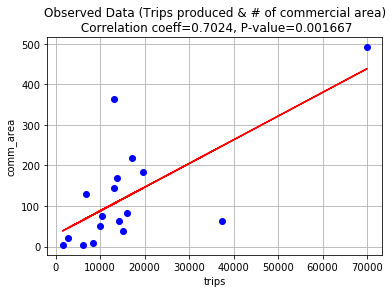

In [45]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_area"], 'bo')
x = df["trips"]
y = df["comm_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_area')
plt.title('Observed Data (Trips produced & # of commercial area)\n Correlation coeff=0.7024, P-value=0.001667')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

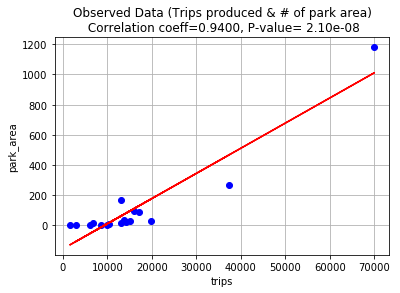

In [17]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["park_area"], 'bo')
x = df["trips"]
y = df["park_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('park_area')
plt.title('Observed Data (Trips produced & # of park area)\n Correlation coeff=0.9400, P-value= 2.10e-08')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

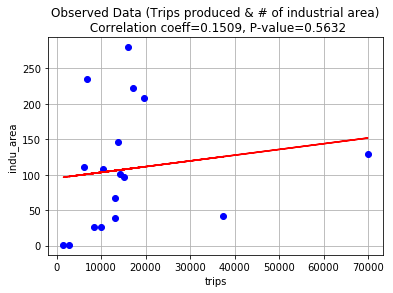

In [43]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["indu_area"], 'bo')
x = df["trips"]
y = df["indu_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('indu_area')
plt.title('Observed Data (Trips produced & # of industrial area)\n Correlation coeff=0.1509, P-value=0.5632')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

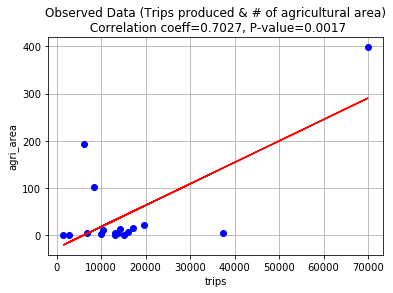

In [11]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["agri_area"], 'bo')
x = df["trips"]
y = df["agri_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('agri_area')
plt.title('Observed Data (Trips produced & # of agricultural area)\n Correlation coeff=0.7027, P-value=0.0017')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

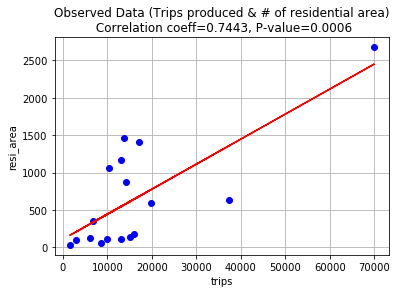

In [40]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["resi_area"], 'bo')
x = df["trips"]
y = df["resi_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('resi_area')
plt.title('Observed Data (Trips produced & # of residential area)\n Correlation coeff=0.7443, P-value=0.0006')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

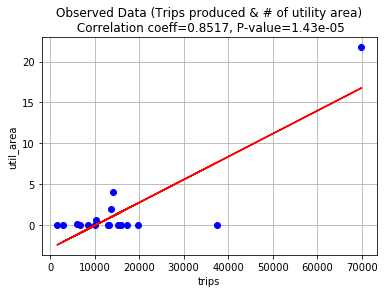

In [41]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["util_area"], 'bo')
x = df["trips"]
y = df["util_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('util_area')
plt.title('Observed Data (Trips produced & # of utility area)\n Correlation coeff=0.8517, P-value=1.43e-05')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

### Verify Collinearity through Scatter Plots

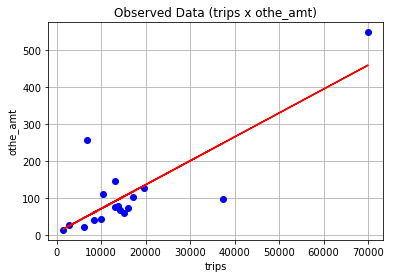

In [11]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["othe_amt"], 'bo')
x = df["trips"]
y = df["othe_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('othe_amt')
plt.title('Observed Data (trips x othe_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

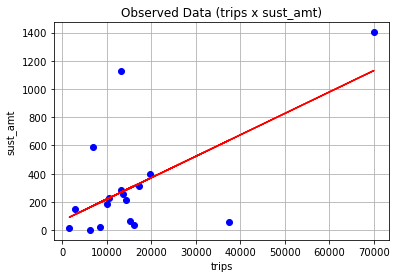

In [12]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["sust_amt"], 'bo')
x = df["trips"]
y = df["sust_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('sust_amt')
plt.title('Observed Data (trips x sust_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

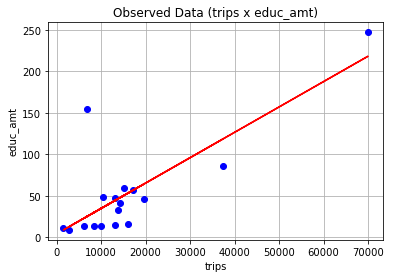

In [13]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["educ_amt"], 'bo')
x = df["trips"]
y = df["educ_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('educ_amt')
plt.title('Observed Data (trips x educ_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

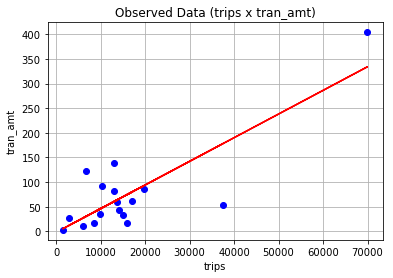

In [14]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["tran_amt"], 'bo')
x = df["trips"]
y = df["tran_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('tran_amt')
plt.title('Observed Data (trips x tran_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

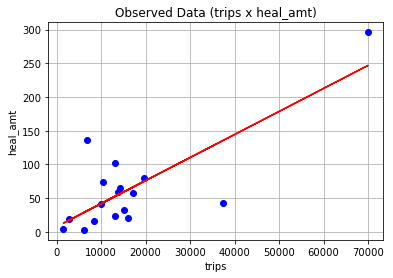

In [15]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["heal_amt"], 'bo')
x = df["trips"]
y = df["heal_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('heal_amt')
plt.title('Observed Data (trips x heal_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

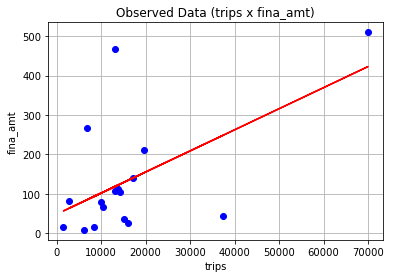

In [16]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["fina_amt"], 'bo')
x = df["trips"]
y = df["fina_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('fina_amt')
plt.title('Observed Data (trips x fina_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

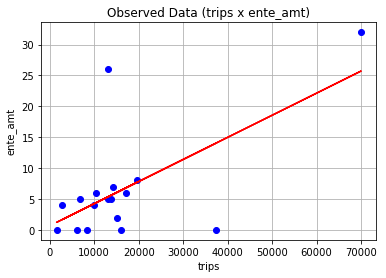

In [17]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["ente_amt"], 'bo')
x = df["trips"]
y = df["ente_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('ente_amt')
plt.title('Observed Data (trips x ente_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

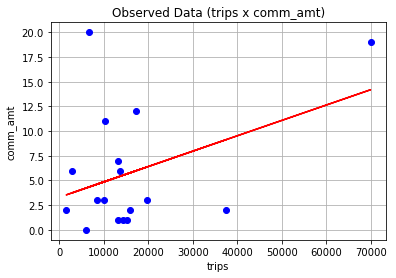

In [18]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_amt"], 'bo')
x = df["trips"]
y = df["comm_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_amt')
plt.title('Observed Data (trips x comm_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

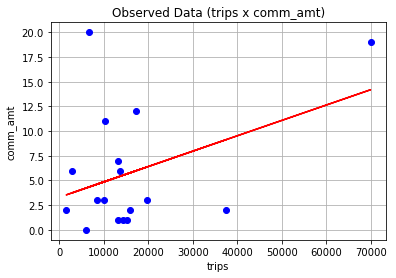

In [19]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_amt"], 'bo')
x = df["trips"]
y = df["comm_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_amt')
plt.title('Observed Data (trips x comm_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

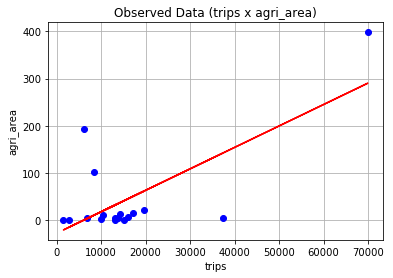

In [20]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["agri_area"], 'bo')
x = df["trips"]
y = df["agri_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('agri_area')
plt.title('Observed Data (trips x agri_area)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

In [ ]:
Collinearity between no_hh & trips = (0.92914760415527753, 7.1205170410730196e-08)
Collinearity between avg_income & trips = (0.91992035789848337, 1.7354578828442896e-07)
Collinearity between mem_no & trips = (0.91247798270778113, 3.305852610863916e-07)
Collinearity between no_mem_educwork & trips = (0.91764041951966036, 2.1277373172145904e-07)

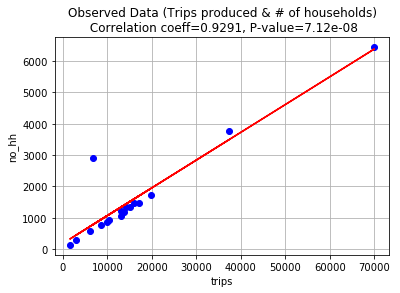

In [29]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["no_hh"], 'bo')
x = df["trips"]
y = df["no_hh"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('no_hh')
plt.title('Observed Data (Trips produced & # of households)\n Correlation coeff=0.9291, P-value=7.12e-08')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

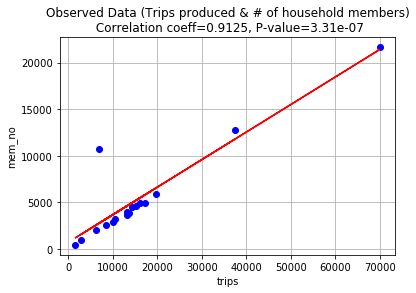

In [30]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["mem_no"], 'bo')
x = df["trips"]
y = df["mem_no"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('mem_no')
plt.title('Observed Data (Trips produced & # of household members)\n Correlation coeff=0.9125, P-value=3.31e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

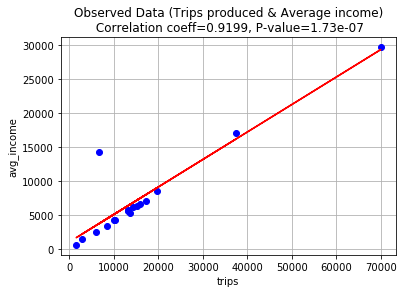

In [31]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["avg_income"], 'bo')
x = df["trips"]
y = df["avg_income"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('avg_income')
plt.title('Observed Data (Trips produced & Average income)\n Correlation coeff=0.9199, P-value=1.73e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

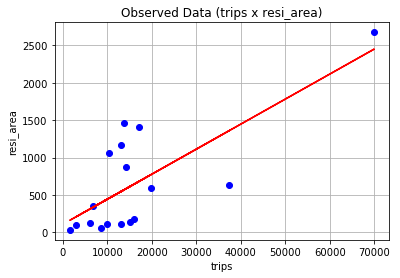

In [24]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["resi_area"], 'bo')
x = df["trips"]
y = df["resi_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('resi_area')
plt.title('Observed Data (trips x resi_area)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

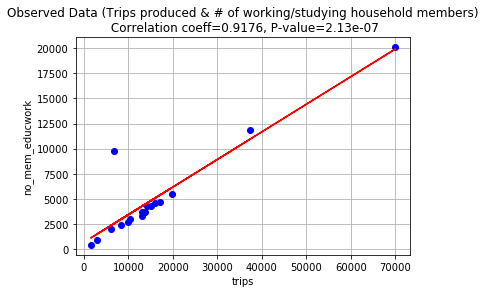

In [32]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["no_mem_educwork"], 'bo')
x = df["trips"]
y = df["no_mem_educwork"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('no_mem_educwork')
plt.title('Observed Data (Trips produced & # of working/studying household members)\n Correlation coeff=0.9176, P-value=2.13e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

In [12]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Autos"], 'bo')
x = df["Trips"]
y = df["Autos"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (TRIPS x AUTOS)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

KeyError: 'Trips'

# Generate table that contains the aggregated information per zone, given the TAZ input file and the Households input file (income, houses, # amenities of each kind)

#### Create TripGenTableModel:
wherein its attributes are the columns in the table example (Out 348, remove trips column, shape coordinate, landuse).

#### Get number of TAZs
#### Get number of landuse per TAZ
#### Create [ ][ ] of TripGenTableModel

#### SAMPLE CODE
TripGenTableModel tgtm = [# of TAZs][ ]
for n in range(0,len(TAZ)):
    LUShapes lus = getImpactingShapes(TAZ[n]) #Returns the whole shape coors of impacting landuses together with its category
    for x in range(0, len(lus)):
        tgtm[n][x] = new TripGenTableModel()
        tgtm[n][x].setShapeCoordinate(TAZ[n], lus[x]) #sets a coor shape for the overlapping of the TAZ shape and landuse shape
        
for cbms_file in cmbs_files:
    for row in cbms_file:
        lat, long = getCoor(row)
        add_info_to_respective_TGTM(lat, long, row) #adds the info of the HH to the correct zone and landuse
        
        
        
        



# Detemine landuse of each zone using the land use file

# Get the corresponding trip productions and attractions per zone given the parameters

# MODEL FITTING

### Retreival of intercepts and coefficients
**Features for Trip production**: # of HH, # of HH members, # of employed, # of enrolled, Income, Landuse and Amenity Data

**Features for Trip attraction**: # of Establishments, # of working in area, # of enrolled in area, Landuse and Amenity Data

In [51]:
dep_col_name = "trips"
data_filepath = "DummyDataRegressionHHTripsOnly2.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegressionHHTripsOnly.csv', index_col=0)
dummy_data.head()

Prod Intercept:-3.40665419102 Coef:[ 51.75074465   5.63282579 -49.56922453  31.8582276 ]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,trips
1.0,3779.0,17110.0,12747.0,11894.0,37428.0
2.0,1349.0,6272.0,4509.0,4238.0,14213.0
3.0,1060.0,5670.0,3624.0,3321.0,13730.0
4.0,767.0,3390.0,2598.0,2402.0,8437.0
5.0,862.0,4271.0,2913.0,2720.0,11306.0


In [52]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("Trained using index "+str(x)+": RMS = "+str(rms))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
Test row: 0
Trained using index 0: RMS = 1642.8611353042031
Test row: 1
Trained using index 1: RMS = 1623.0075678854153
Test row: 2
Trained using index 2: RMS = 1613.9679788752348
Test row: 3
Trained using index 3: RMS = 1626.248724401083
Test row: 4
Trained using index 4: RMS = 1598.2276558902588
Test row: 5
Trained using index 5: RMS = 5983.535008027696
Test row: 6
Trained using index 6: RMS = 1604.1427427182311
Test row: 7
Trained using index 7: RMS = 1601.8320898685502
Test row: 8
Trained using index 8: RMS = 1641.223576273628
Test row: 9
Trained using index 9: RMS = 1614.0143609756592
Test row: 10
Trained using index 10: RMS = 1651.3620291500129
Test row: 11
Trained using index 11: RMS = 1615.7890835165513
Test row: 12
Trained using index 12: RMS = 1597.9605414533635
Test row: 13
Trained using index 13: RMS = 2396.378970999385
Test row: 14
Trained using index 14: RMS = 1598.4290560976747
Test row: 15
Trained using index 15: RMS 

In [12]:
rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
rms

1610.5698820074329

In [49]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

Prod Intercept:-1334.37618541 Coef:[  65.38103342   11.84731132  -39.93400213    8.23285102  -25.241787
   -1.2510184     2.20551241   31.82834803    3.07411895 -483.96528568
    0.        ]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


In [14]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("Trained using index "+str(x)+": RMS = "+str(rms))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Trained using index 0: RMS = 1199.5001738604585
Test row: 1
Trained using index 1: RMS = 1547.9030966594698
Test row: 2
Trained using index 2: RMS = 1698.625401997352
Test row: 3
Trained using index 3: RMS = 1110.0157677369214
Test row: 4
Trained using index 4: RMS = 1120.3091382352047
Test row: 5
Trained using index 5: RMS = 6355.031539135825
Test row: 6
Trained using index 6: RMS = 1195.6302454347829
Test row: 7
Trained using index 7: RMS = 1108.7031494098974
Test row: 8
Trained using index 8: RMS = 1349.631568485247
Test row: 9
Trained using index 9: RMS = 1279.7077221123982
Test row: 10
Trained using index 10: RMS = 1224.9653657836998
Test row: 11
Trained using index 11: RMS = 1402.5687467678567
Test row: 12
Trained using index 12: RMS = 1127.1752948891544
Test row: 13
Trained using index 13: RMS = 9677.540234006443
Test row: 14

In [15]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)
Predicted_vals = []
for x in range(len(X_vals.index)):
    
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    #fitted
    print("Actual Zone "+str(x)+": "+str(Y_vals.iloc[x]))
    print("Predicted Zone "+str(x)+": "+str(fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0]))
    Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Actual Zone 0: 37428
Predicted Zone 0: 39382.3380619
Test row: 1
Actual Zone 1: 14213
Predicted Zone 1: 19526.3490053
Test row: 2
Actual Zone 2: 13093
Predicted Zone 2: 7441.57239735
Test row: 3
Actual Zone 3: 8437
Predicted Zone 3: 7974.96642417
Test row: 4
Actual Zone 4: 9969
Predicted Zone 4: 11257.1188113
Test row: 5
Actual Zone 5: 6779
Predicted Zone 5: 32935.0870259
Test row: 6
Actual Zone 6: 10373
Predicted Zone 6: 7778.4585352
Test row: 7
Actual Zone 7: 13713
Predicted Zone 7: 14016.8440844
Test row: 8
Actual Zone 8: 6084
Predicted Zone 8: 9592.43907124
Test row: 9
Actual Zone 9: 17149
Predicted Zone 9: 20425.8402604
Test row: 10
Actual Zone 10: 13107
Predicted Zone 10: 16291.1746307
Test row: 11
Actual Zone 11: 19694
Predicted Zone 11: 15635.8845075
Test row: 12
Actual Zone 12: 1542
Predicted Zone 12: 127.599465386
Test row

In [16]:
rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
rms

11905.485868129843

In [17]:
fitted_production_model2, testdframe = regression.kFoldTest(selected_feature_names, dep_col_name, 1)
X_vals = regression.getXVals(selected_feature_names)
testdframe.head()
fitted_production_model2.predict(X_vals.loc[1 , :])

TypeError: 'LinearRegression' object is not iterable

### Prediction of Trip Production & Attraction using the intercepts and coefficients

In [28]:
trip_gen = TripGeneration("DummyDataRegressionFused.csv", "trips")
prod_col_names = selected_feature_names
attr_col_names = selected_feature_names_attraction
trip_gen.setProductionParameters(prod_col_names, fitted_production_model.intercept_, fitted_production_model.coef_)
trip_gen.setAttractionParameters(attr_col_names, fitted_production_model_attr.intercept_, fitted_production_model_attr.coef_)
print("Example:")
print("Overall Trip Production: "+str(trip_gen.getWholeTripProductionScore()))
print("Overall Trip Attraction: "+str(trip_gen.getWholeTripAttractionScore()))

Example:
Overall Trip Production: 275486
Overall Trip Attraction: 275490


### Computing for Trip Balancing Factor

In [29]:
trip_gen.doTripBalancing()
print("Balancing Factor: "+str(trip_gen.getBalancingFactor()))


Balancing Factor: 0.99998516679


### Zonal-level Trip Production & Attraction Scores

In [12]:
zonal_df, productions, attractions = trip_gen.printAllZonalTripsProductionAttraction()
display(zonal_df)

,Trip Production,Trip Atraction
1,5545.0,5866.0
2,5307.0,5613.0
3,5793.0,5783.0
4,5828.0,6015.0
5,5754.0,5725.0
6,6335.0,6381.0
7,4876.0,5231.0
8,4968.0,4589.0
9,5841.0,5712.0
10,4609.0,5229.0


# Model Validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
X_digits = regression.getSubTable(selected_feature_names)
Y_digits = regression.getSubTable(dep_col_name)
scores = cross_validation.cross_val_score(fitted_production_model, X_digits, Y_digits, scoring='r2', cv=10,)
#X_digits.shape, Y_digits.shape
scores

# MODEL OUTPUT

# Trip Distribution Class

In [13]:
class TripDistribution:

    def __init__(self, productions, attractions):
        self.productions = productions
        self.attractions = attractions
        self.row = len(productions)
        self.col = len(attractions)
        self.possibleError = 3
        self.error = 0

    def getGeneralizedCost(self, cost):
        return 1.0 / (cost * cost)

    def getTripDistribution(self):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        costMatrix = [[1 for x in range(self.row)] for y in range(self.col)]
        #costMatrix = [[1.0, 1.2, 1.8], [1.2, 1.0, 1.5], [1.8, 1.5, 1.0]]
        A = [1 for x in range(self.row)]
        B = [1 for x in range(self.col)]

        currentBalancingFactor = 0  # 0 for A, 1 for B
        isConvergent = False

        while isConvergent == False:
            if currentBalancingFactor == 0:
                A = self.computeA(B, costMatrix)
                currentBalancingFactor = 1
            elif currentBalancingFactor == 1:
                B = self.computeB(A, costMatrix)
                currentBalancingFactor = 0
            distributions = self.computeDistributions(A, B, costMatrix)
            isConvergent = self.checkIfConvergent(distributions)
        return distributions

    def computeDistributions(self, A, B, costMatrix):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        for x in range(self.row):
            for y in range(self.col):
                distributions[x][y] = A[x] * self.productions[x] * B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
        return distributions

    def checkIfConvergent(self, distributions):
        error = self.getError(distributions)
        if error <= self.possibleError:
            self.error = error
            return True
        return False

    def getError(self, distributions):
        error = 0
        derivedProductions = [0 for x in range(self.row)]
        derivedAttractions = [0 for x in range(self.col)]

        for x in range(self.row):
            for y in range(self.col):
                derivedProductions[x] += distributions[x][y]
                derivedAttractions[y] += distributions[x][y]

        for x in range(self.row):
            error += abs(derivedProductions[x] - self.productions[x])
            error += abs(derivedAttractions[y] - self.attractions[y])

        return error

    def computeA(self, B, costMatrix):
        A = [1 for x in range(self.row)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
            A[x] = 1.0 / sum
        return A

    def computeB(self, A, costMatrix):
        B = [1 for x in range(self.col)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += A[y] * self.productions[y] * self.getGeneralizedCost(costMatrix[x][y])
            B[x] = 1.0 / sum
        return B

# Data

## The result from trip generation (trip production and attraction) will be passed to trip distribution

In [ ]:
td = TripDistribution(productions, attractions)

#pandas_distrib = pd.DataFrame(td, columns=('1','2'))

#print("Productions: " + str(productions))
#print("Attractions: " + str(attractions))

In [27]:
distribution = td.getTripDistribution()

pandas_distrib = pd.DataFrame(distribution, columns=range(0,len(productions)))

# pandas_distrib.head()
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in distribution)
        )
))

131.68813765182188,126.00844129554658,129.8248380566802,135.03309716599193,128.52277327935224,143.24957489878545,117.43277327935225,103.02026315789475,128.23093117408908,117.38787449392714,125.46965587044537,143.2271255060729,127.46765182186236,111.05714574898788,149.71500000000003,137.12089068825912,97.76710526315792,124.01044534412958,130.16157894736844,148.83947368421056,141.4985222672065,133.08,111.57348178137653,154.78856275303647,143.06997975708504,112.47145748987856,115.70417004048585,146.23534412955468,99.42836032388665,138.3556072874494,93.45682186234819,144.30469635627531,94.71398785425103,129.30850202429153,111.37143724696358,149.26601214574902,103.49170040485832,133.08,129.1289068825911,106.47746963562754,111.05714574898788,133.01265182186236,124.16759109311742,130.65546558704455
126.03587854251015,120.59996356275306,124.25255465587047,129.23726720647775,123.00637651821864,137.10108097165994,112.39237651821864,98.59847368421055,122.72706072874496,112.34940485829962,120.08430364372472,137.07959514170042,121.99654251012149,106.29040080971662,143.28900000000002,131.23544939271258,93.57078947368423,118.6877246963563,124.57484210526319,142.451052631579,135.42518623481783,127.36800000000002,106.78457489878545,148.14479757085024,136.92919433198384,107.64400809716601,110.73796761133606,139.95869635627534,95.16074089068827,132.41717004048584,89.4455101214575,138.11091497975713,90.64871659919031,123.75838056680165,106.59120242914982,142.85928340080974,99.04967611336035,127.36800000000002,123.58649392712553,101.90729149797573,106.29040080971662,127.30354251012149,118.8381255060729,125.04753036437249
137.57788663967614,131.64416599190284,135.63125101214575,141.07244939271257,134.27095141700406,149.6564089068826,122.68495141700406,107.62784210526317,133.96605668016196,122.63804453441297,131.08128340080972,149.63295546558706,133.16863967611337,116.02417408906884,156.41100000000003,143.2536194331984,102.13973684210528,129.55680971659922,135.98305263157897,155.4963157894737,147.82704048582997,139.032,116.5636032388664,161.71147773279355,149.46878137651822,117.50174089068827,120.87903643724698,152.7757165991903,103.87529149797572,144.54355870445346,97.63667611336034,150.7587206477733,98.95006882591095,135.09182186234818,116.3525222672065,155.9419311740891,108.12036437246965,139.032,134.90419433198383,111.23967206477734,116.02417408906884,138.96163967611338,129.72098380566803,136.499028340081
138.40910121457492,132.4395303643725,136.45070445344132,141.92477732793526,135.08218623481784,150.56059919028343,123.42618623481783,108.27810526315791,134.77544939271257,123.37899595141702,131.87324696356276,150.53700404858301,133.9732145748988,116.72516599190286,157.35600000000002,144.1191255060729,102.75684210526317,130.33956275303646,136.80463157894738,156.43578947368425,148.72017813765186,139.872,117.26785425101217,162.68850202429152,150.3718380566802,118.21165991902836,121.60936032388666,153.69875303643727,104.50288259109314,145.41685829959516,98.22657489878544,151.66957085020246,99.54790283400811,135.90801619433202,117.05549797570852,156.88409716599193,108.77360323886641,139.872,135.71925506072876,111.91175708502027,116.72516599190286,139.8012145748988,130.50472874493929,137.3237246963563
136.65167611336034,130.75790283400812,134.7181457489879,140.1227125506073,133.36700404858303,148.64888259109316,121.85900404858302,106.90326315789476,133.06416194331987,121.81241295546562,130.19880971659921,148.62558704453446,132.2721133603239,115.24306882591095,155.35800000000003,142.28919838056683,101.45210526315792,128.68459919028342,135.06757894736845,154.44947368421055,146.8318299595142,138.09600000000003,115.77886639676116,160.62279352226724,148.4625182186235,116.71068825910933,120.06524696356277,151.74719028340084,103.17597570850205,143.57045344129557,96.97936032388665,149.74377327935227,98.2839109311741,134.1823481781377,115.56920647773282,154.89208906882595,107.39246963562755,138.09600000000003,133.99598380566803,110.49077732793525,115.243068825

# Error

In [355]:
print("Error: " + str(td.error))

Error: 2.9999999999936335


# Modal Split Class

In [430]:
import random
class ModalSplit:

    def __init__(self, od_matrix, pathToData):
        self.od_matrix = od_matrix
        self.pathToData = pathToData
        self.travel_costs = []
        self.travel_probabilities = []
        self.modes = ['jeep','bus','train']
        
    def computeGeneralizedCosts(self, zone_number):
        #data = pd.read_csv(self.pathToData, index_col=0)
        self.travel_costs = [None] * len(self.modes)
        for x in range(0, len(self.modes)):
            self.travel_costs[x] = random.randrange(1,4)
            
        #Compute for generalized cost for each mode for this specific zone
        # populate self.travel_costs with the travel costs
        self.computeModalProbabilities()
        
    def computeModalProbabilities(self):
        self.travel_probabilities = [None] * len(self.modes)
        sum = 0
        #print(len(self.travel_costs))
        for x in range(0,3):
            sum += exp(-self.travel_costs[x])
        for x in range(0,3):
            self.travel_probabilities[x] = exp(-self.travel_costs[x])/sum
        #print(self.travel_costs)
        #print(self.travel_probabilities)
    
    def getPartitionedTripsByMode(self, total_trips):
        return total_trips*self.travel_probabilities[0], self.travel_probabilities[1], self.travel_probabilities[2]
    
    def process_od_matrix(self):
        #print("size:"+str(len(self.od_matrix))+","+str(len(self.od_matrix[0])))
        #df = DataFrame(columns=('lib', 'qty1', 'qty2'))
        #for i in range(5):
            #df.loc[i] = [randint(-1,1) for n in range(3)]
        cols = list(range(len(self.od_matrix[0])))
        df_list = []
        for x in range(0, len(self.modes)):
            df = pd.DataFrame(columns=cols) 
            df_list.append(df)
            
        for y in range(0, len(self.od_matrix)):
            self.computeGeneralizedCosts(y)
            for z in range(0, len(self.modes)):
                od_row = []
                for x in range(0, len(self.od_matrix[0])):
                    #print("x:"+str(x)+" y:"+str(y)+" z:"+str(z))
                    od_row.append(round(self.od_matrix[x][y]*self.travel_probabilities[z],2))
                df_list[z].loc[y] = od_row
                
        return df_list
                

In [431]:
modal_split = ModalSplit(distribution,"datapath")
list_of_dataframes_by_mode = modal_split.process_od_matrix()

## Mode 1

In [432]:
display(list_of_dataframes_by_mode[0])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,43.90,42.01,45.86,46.14,45.55,50.15,38.60,39.33,46.24,36.49,...,35.96,47.05,50.21,48.83,44.41,33.62,36.64,34.37,42.43,42.78
1,53.22,50.93,55.60,55.93,55.22,60.80,46.80,47.68,56.06,44.23,...,43.59,57.04,60.86,59.19,53.84,40.76,44.42,41.67,51.44,51.86
2,54.83,52.47,57.28,57.63,56.89,62.64,48.21,49.12,57.75,45.57,...,44.91,58.77,62.71,60.99,55.47,41.99,45.77,42.93,53.00,53.43
3,45.01,43.08,47.02,47.31,46.71,51.42,39.58,40.33,47.41,37.41,...,36.87,48.25,51.48,50.07,45.54,34.47,37.58,35.25,43.51,43.87
4,31.45,30.10,32.86,33.06,32.64,35.93,27.66,28.18,33.13,26.14,...,25.76,33.72,35.97,34.99,31.82,24.09,26.26,24.63,30.40,30.65
5,30.36,29.06,31.72,31.91,31.50,34.69,26.70,27.20,31.98,25.24,...,24.87,32.55,34.72,33.77,30.72,23.25,25.35,23.77,29.35,29.59
6,78.12,74.77,81.62,82.11,81.07,89.25,68.70,69.99,82.29,64.93,...,63.99,83.74,89.35,86.90,79.04,59.83,65.22,61.17,75.51,76.13
7,10.97,10.50,11.46,11.53,11.39,12.54,9.65,9.83,11.56,9.12,...,8.99,11.76,12.55,12.21,11.10,8.40,9.16,8.59,10.61,10.69
8,11.54,11.05,12.06,12.13,11.98,13.19,10.15,10.34,12.16,9.60,...,9.46,12.38,13.20,12.84,11.68,8.84,9.64,9.04,11.16,11.25
9,39.13,37.45,40.88,41.13,40.60,44.70,34.41,35.06,41.22,32.52,...,32.05,41.94,44.75,43.53,39.59,29.97,32.67,30.64,37.82,38.13


## Mode 2

In [433]:
display(list_of_dataframes_by_mode[1])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,43.90,42.01,45.86,46.14,45.55,50.15,38.60,39.33,46.24,36.49,...,35.96,47.05,50.21,48.83,44.41,33.62,36.64,34.37,42.43,42.78
1,19.58,18.74,20.45,20.58,20.31,22.37,17.22,17.54,20.62,16.27,...,16.04,20.99,22.39,21.78,19.81,14.99,16.34,15.33,18.92,19.08
2,54.83,52.47,57.28,57.63,56.89,62.64,48.21,49.12,57.75,45.57,...,44.91,58.77,62.71,60.99,55.47,41.99,45.77,42.93,53.00,53.43
3,45.01,43.08,47.02,47.31,46.71,51.42,39.58,40.33,47.41,37.41,...,36.87,48.25,51.48,50.07,45.54,34.47,37.58,35.25,43.51,43.87
4,85.50,81.83,89.32,89.86,88.72,97.68,75.18,76.60,90.06,71.07,...,70.03,91.65,97.79,95.10,86.50,65.48,71.37,66.95,82.65,83.32
5,82.53,78.99,86.22,86.74,85.64,94.29,72.57,73.94,86.93,68.60,...,67.60,88.47,94.39,91.80,83.50,63.21,68.90,64.62,79.78,80.43
6,28.74,27.51,30.02,30.21,29.82,32.83,25.27,25.75,30.27,23.89,...,23.54,30.81,32.87,31.97,29.08,22.01,23.99,22.50,27.78,28.01
7,81.08,77.60,84.70,85.21,84.13,92.63,71.29,72.64,85.40,67.39,...,66.41,86.91,92.73,90.18,82.03,62.10,67.68,63.49,78.37,79.01
8,31.38,30.03,32.79,32.98,32.56,35.85,27.60,28.12,33.06,26.08,...,25.71,33.64,35.89,34.91,31.75,24.04,26.20,24.57,30.33,30.58
9,39.13,37.45,40.88,41.13,40.60,44.70,34.41,35.06,41.22,32.52,...,32.05,41.94,44.75,43.53,39.59,29.97,32.67,30.64,37.82,38.13


## Mode 3

In [434]:
display(list_of_dataframes_by_mode[2])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,43.90,42.01,45.86,46.14,45.55,50.15,38.60,39.33,46.24,36.49,...,35.96,47.05,50.21,48.83,44.41,33.62,36.64,34.37,42.43,42.78
1,53.22,50.93,55.60,55.93,55.22,60.80,46.80,47.68,56.06,44.23,...,43.59,57.04,60.86,59.19,53.84,40.76,44.42,41.67,51.44,51.86
2,20.17,19.30,21.07,21.20,20.93,23.04,17.74,18.07,21.25,16.77,...,16.52,21.62,23.07,22.44,20.41,15.45,16.84,15.79,19.50,19.66
3,45.01,43.08,47.02,47.31,46.71,51.42,39.58,40.33,47.41,37.41,...,36.87,48.25,51.48,50.07,45.54,34.47,37.58,35.25,43.51,43.87
4,11.57,11.07,12.09,12.16,12.01,13.22,10.17,10.37,12.19,9.62,...,9.48,12.40,13.23,12.87,11.71,8.86,9.66,9.06,11.18,11.28
5,30.36,29.06,31.72,31.91,31.50,34.69,26.70,27.20,31.98,25.24,...,24.87,32.55,34.72,33.77,30.72,23.25,25.35,23.77,29.35,29.59
6,10.57,10.12,11.05,11.11,10.97,12.08,9.30,9.47,11.14,8.79,...,8.66,11.33,12.09,11.76,10.70,8.10,8.83,8.28,10.22,10.30
7,10.97,10.50,11.46,11.53,11.39,12.54,9.65,9.83,11.56,9.12,...,8.99,11.76,12.55,12.21,11.10,8.40,9.16,8.59,10.61,10.69
8,85.30,81.64,89.12,89.66,88.52,97.46,75.01,76.43,89.86,70.91,...,69.87,91.44,97.57,94.89,86.30,65.34,71.21,66.80,82.46,83.14
9,39.13,37.45,40.88,41.13,40.60,44.70,34.41,35.06,41.22,32.52,...,32.05,41.94,44.75,43.53,39.59,29.97,32.67,30.64,37.82,38.13


## TRIP GENERATION TESTING #7:
Compare the results of including and excluding the landuse dataset to the travel demand model by cross-checking it with the results of other studies

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area']
TOTAL RMSE: 32119.57119413283
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'park_area']
TOTAL RMSE: 32453.221489960008
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'indu_area']
TOTAL RMSE: 33491.384291544644
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'agri_area']
TOTAL RMSE: 24857.53188930825
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'resi_area']
TOTAL RMSE: 32745.21446960277
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'util_area']
TOTAL RMSE: 33516.83630002846
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'othe_area']
TOTAL RMSE: 32672.529698074104
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area']
TOTAL RMSE: 32247.827789884537
current: ['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'indu_area']
TO

### 1.) without LANDUSE variables

In [42]:
dep_col_name = "trips"
data_filepath = "DummyDataRegressionHHTripsOnly2.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

#print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
#print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegressionHHTripsOnly.csv', index_col=0)
dummy_data.head()

R^2 score: 0.989402880694
R^2 score: 0.996911644387


,no_hh,avg_income,mem_no,no_mem_educwork,trips
1.0,3779.0,17110.0,12747.0,11894.0,37428.0
2.0,1349.0,6272.0,4509.0,4238.0,14213.0
3.0,1060.0,5670.0,3624.0,3321.0,13730.0
4.0,767.0,3390.0,2598.0,2402.0,8437.0
5.0,862.0,4271.0,2913.0,2720.0,11306.0


## Additional regression info:

In [61]:
dep_col_name = "trips"
data_filepath = "DummyDataRegressionHHTripsOnly2.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
result = regression.statsmodelsRegressionSummary(selected_feature_names, dep_col_name)
result.summary()

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trips   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     644.6
Date:                Mon, 12 Jun 2017   Prob (F-statistic):           8.43e-15
Time:                        22:19:24   Log-Likelihood:                -149.52
No. Observations:                  17   AIC:                             307.0
Df Residuals:                      13   BIC:                             310.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
no_hh              51.7880     19.195      2.698      0.018      10.320      93.256
avg_income          5.6289      1.805      3.118      0.008       1.729       9.528
mem_no            -49.5445     12.667     -3.911      0.002     -76.911     -22.178
no_mem_educwork    31.8253     18.000      1.768      0.100      -7.061      70.711
==============================================================================
Omnibus:                        5.307   Durbin-Watson:                   2.264
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                1.514
Skew:                          -0.104   Prob(JB):                        0.469
Kurtosis:                       1.553   Cond. No.                         940.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## K-fold validation (6-fold) and measuring by % RMSE values

In [34]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)
regression.kFoldTest2(selected_feature_names, dep_col_name, 3)


['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
length:17 index:0
37428
length:17 index:1
14213
length:17 index:2
13730
Trained using slice 0: RMSE = 7.94854293484
slice size: 3
length:17 index:3
8437
length:17 index:4
11306
length:17 index:5
6921
Trained using slice 1: RMSE = 15.4169238521
slice size: 3
length:17 index:6
10373
length:17 index:7
13713
length:17 index:8
6084
Trained using slice 2: RMSE = 16.6974113882
slice size: 3
length:17 index:9
17257
length:17 index:10
13211
length:17 index:11
19694
Trained using slice 3: RMSE = 11.7297137922
slice size: 3
length:17 index:12
1542
length:17 index:13
70165
length:17 index:14
3099
Trained using slice 4: RMSE = 4.15708071333
slice size: 3
length:17 index:15
15994
length:17 index:16
15132
Trained using slice 5: RMSE = 16.043440092
slice size: 2


## K-fold validation (17-fold)

In [16]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("raw RMSE: "+str(rms))
    rms = rms*((100*17)/sum(Y_vals.values))
    totalrmse += rms
    print("Trained using index "+str(x)+": %RMSE = "+str(rms))
print("TOTAL RMSE: "+str(totalrmse))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
Test row: 0
raw RMSE: 1642.8611353042031
Trained using index 0: %RMSE = 10.0354795742
Test row: 1
raw RMSE: 1623.0075678854153
Trained using index 1: %RMSE = 9.91420330438
Test row: 2
raw RMSE: 1613.9679788752348
Trained using index 2: %RMSE = 9.85898463195
Test row: 3
raw RMSE: 1626.248724401083
Trained using index 3: %RMSE = 9.93400203192
Test row: 4
raw RMSE: 1598.2276558902588
Trained using index 4: %RMSE = 9.76283427182
Test row: 5
raw RMSE: 5983.535008027696
Trained using index 5: %RMSE = 36.5506506083
Test row: 6
raw RMSE: 1604.1427427182311
Trained using index 6: %RMSE = 9.79896680412
Test row: 7
raw RMSE: 1601.8320898685502
Trained using index 7: %RMSE = 9.78485209353
Test row: 8
raw RMSE: 1641.223576273628
Trained using index 8: %RMSE = 10.0254764827
Test row: 9
raw RMSE: 1614.0143609756592
Trained using index 9: %RMSE = 9.85926795877
Test row: 10
raw RMSE: 1651.3620291500129
Trained using index 10: %RMSE = 10.0874076068
Te

### 2.) with LANDUSE variables

In [75]:
dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


In [15]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

for L in range(1, len(selected_feature_names+landuse_names)+1):
  for subset in itertools.combinations(selected_feature_names+landuse_names, L):
    curr_cols = list(subset)
    print("current: "+str(curr_cols))
    totalrmse = 0
    for x in range(len(X_vals.index)):
        Predicted_vals = []
        #print("Test row: "+str(x))
        fitted_production_model2 = regression.kFoldTest(curr_cols, dep_col_name, x);
        #testdframe.head()
        #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
        for z in range(len(X_vals.index)):
            #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
            #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
            #print("subset"+str(list(subset)))
            Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].loc[curr_cols].values.reshape(1,-1))[0])
        rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
        totalrmse += rms
        #print("Trained using index "+str(x)+": RMSE = "+str(rms))
    print("TOTAL RMSE: "+str(totalrmse))
    if(initialized == False):
        best_score = totalrmse
        initialized = True 
        best_comb = curr_cols
    else:
        if(totalrmse < best_score):
            best_score = totalrmse
            best_comb = curr_cols
print("\n \nBest Score: "+str(best_score))
print("Best Combination: "+str(best_comb)) 


['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
current: ['no_hh']
TOTAL RMSE: 99351.72965131303
current: ['avg_income']
TOTAL RMSE: 105460.19057074863
current: ['mem_no']
TOTAL RMSE: 110109.41658928366
current: ['no_mem_educwork']
TOTAL RMSE: 106915.4001871396
current: ['comm_area']
TOTAL RMSE: 191814.47044528034
current: ['park_area']
TOTAL RMSE: 96857.69191225029
current: ['indu_area']
TOTAL RMSE: 261774.06466485042
current: ['agri_area']
TOTAL RMSE: 196364.26517862413
current: ['resi_area']
TOTAL RMSE: 179600.9828876851
current: ['util_area']
TOTAL RMSE: 145125.46260501712
current: ['no_hh', 'avg_income']
TOTAL RMSE: 89319.60012562927
current: ['no_hh', 'mem_no']
TOTAL RMSE: 37624.98532077694
current: ['no_hh', 'no_mem_educwork']
TOTAL RMSE: 41635.084797421594
current: ['no_hh', 'comm_area']
TOTAL RMSE: 94380.49703661667
current: ['no_hh', 'park_area']
TOTAL RMSE: 77265.97056914525
current: ['no_hh', 'indu_area']
TOTAL RMSE: 95951.03219171868
current: ['no_hh', 'agri_area']
TO

## TRIP GENERATION TESTING #6:
Examine the effect of increasing/decreasing the number of each of the types of landuse per zone, and verify its effect to the number of trips produced and attracted per zone

## Base/Original data 

In [18]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


## Case 1:
Using the 1st row of the original data (zone 1), increase the number of residential areas, and check its effect to the resulting trips produced.

In [31]:
data_filepath2 = "DummyDataRegressionEXP6.csv"
regression2 = Regression(data_filepath2)
dummy_data = pd.read_csv(data_filepath2, index_col=0)
dummy_data.head()

,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,1500.00,0.00,0
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0


## Case 1 Result:
The predicted number of trips produced from zone 1, given the original number of residential areas.

In [32]:
X_vals = regression.getXVals(selected_feature_names)
fitted_production_model.predict(X_vals.iloc[0 , :].values.reshape(1,-1))[0]

37528.186762862118

The predicted number of trips produced from zone 1, given that the number of residential areas were increased.

In [33]:
X_vals = regression2.getXVals(selected_feature_names)
fitted_production_model.predict(X_vals.iloc[0 , :].values.reshape(1,-1))[0]

40205.867335031719

# Scatter plots for the zonal trips produced of other studies

## 1.) HHIS from MUCEP

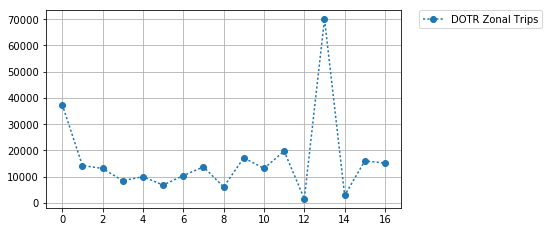

In [15]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), Y_vals.values, label="DOTR Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.) A study based on MUCEP

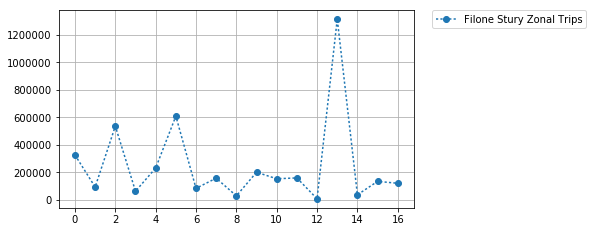

In [16]:
FILONE_MUCEP_TRIP_PROD = [326411,93639,535638,63112,231470,608551,84204,157800,29288,200924,153585
                        ,159682,7882,1313553,37197,134726,120622]
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), FILONE_MUCEP_TRIP_PROD, label="Filone Stury Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# SCRATCH CELLS:

In [21]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

Prod Intercept:-1334.37618541 Coef:[  65.38103342   11.84731132  -39.93400213    8.23285102  -25.241787
   -1.2510184     2.20551241   31.82834803    3.07411895 -483.96528568
    0.        ]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


In [26]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    totalrmse += rms
    print("Trained using index "+str(x)+": RMSE = "+str(rms))
print("TOTAL RMSE: "+str(totalrmse))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Trained using index 0: RMSE = 1199.5001738604585
Test row: 1
Trained using index 1: RMSE = 1547.9030966594698
Test row: 2
Trained using index 2: RMSE = 1698.625401997352
Test row: 3
Trained using index 3: RMSE = 1110.0157677369214
Test row: 4
Trained using index 4: RMSE = 1120.3091382352047
Test row: 5
Trained using index 5: RMSE = 6355.031539135825
Test row: 6
Trained using index 6: RMSE = 1195.6302454347829
Test row: 7
Trained using index 7: RMSE = 1108.7031494098974
Test row: 8
Trained using index 8: RMSE = 1349.631568485247
Test row: 9
Trained using index 9: RMSE = 1279.7077221123982
Test row: 10
Trained using index 10: RMSE = 1224.9653657836998
Test row: 11
Trained using index 11: RMSE = 1402.5687467678567
Test row: 12
Trained using index 12: RMSE = 1127.1752948891544
Test row: 13
Trained using index 13: RMSE = 9677.54023400644

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

#print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
#print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()